In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tabulate import tabulate

## cities data

In [2]:
#reading funda data
ams=pd.read_csv(r'C:\Users\dodih\Documents\Python Scripts\Thesis data\Data\amsterdam_clean.csv')
rot=pd.read_csv(r'C:\Users\dodih\Documents\Python Scripts\Thesis data\Data\rotterdam_clean.csv')
utr=pd.read_csv(r'C:\Users\dodih\Documents\Python Scripts\Thesis data\Data\utrecht_clean.csv')
denh=pd.read_csv(r'C:\Users\dodih\Documents\Python Scripts\Thesis data\Data\den_haag_clean.csv')
funda = pd.concat([ams,rot,utr,denh])

In [3]:
len(funda)

21064

# Data Exploration

In [4]:
#descriptive statistics 
funda.describe()

,price,price_m2,living_area,year_built,house_age,term_days,number
count,2.106400e+04,21064.000000,21064.000000,21064.000000,21064.000000,21064.000000,21048.000000
mean,5.060761e+05,5468.235497,95.387248,1919.782235,103.217765,38.821971,132.550789
std,3.264825e+05,1983.650875,50.758159,258.116354,258.116354,37.603556,214.212790
min,9.000000e+04,134.700000,11.000000,0.000000,0.000000,-47.000000,1.000000
25%,3.250000e+05,3963.400000,66.000000,1925.000000,33.000000,19.000000,24.000000
50%,4.250000e+05,4973.700000,86.000000,1953.000000,70.000000,26.000000,62.000000
75%,5.890000e+05,6820.275000,115.000000,1990.000000,98.000000,43.000000,150.000000
max,1.050000e+07,34426.200000,3600.000000,2023.000000,2023.000000,596.000000,7311.000000


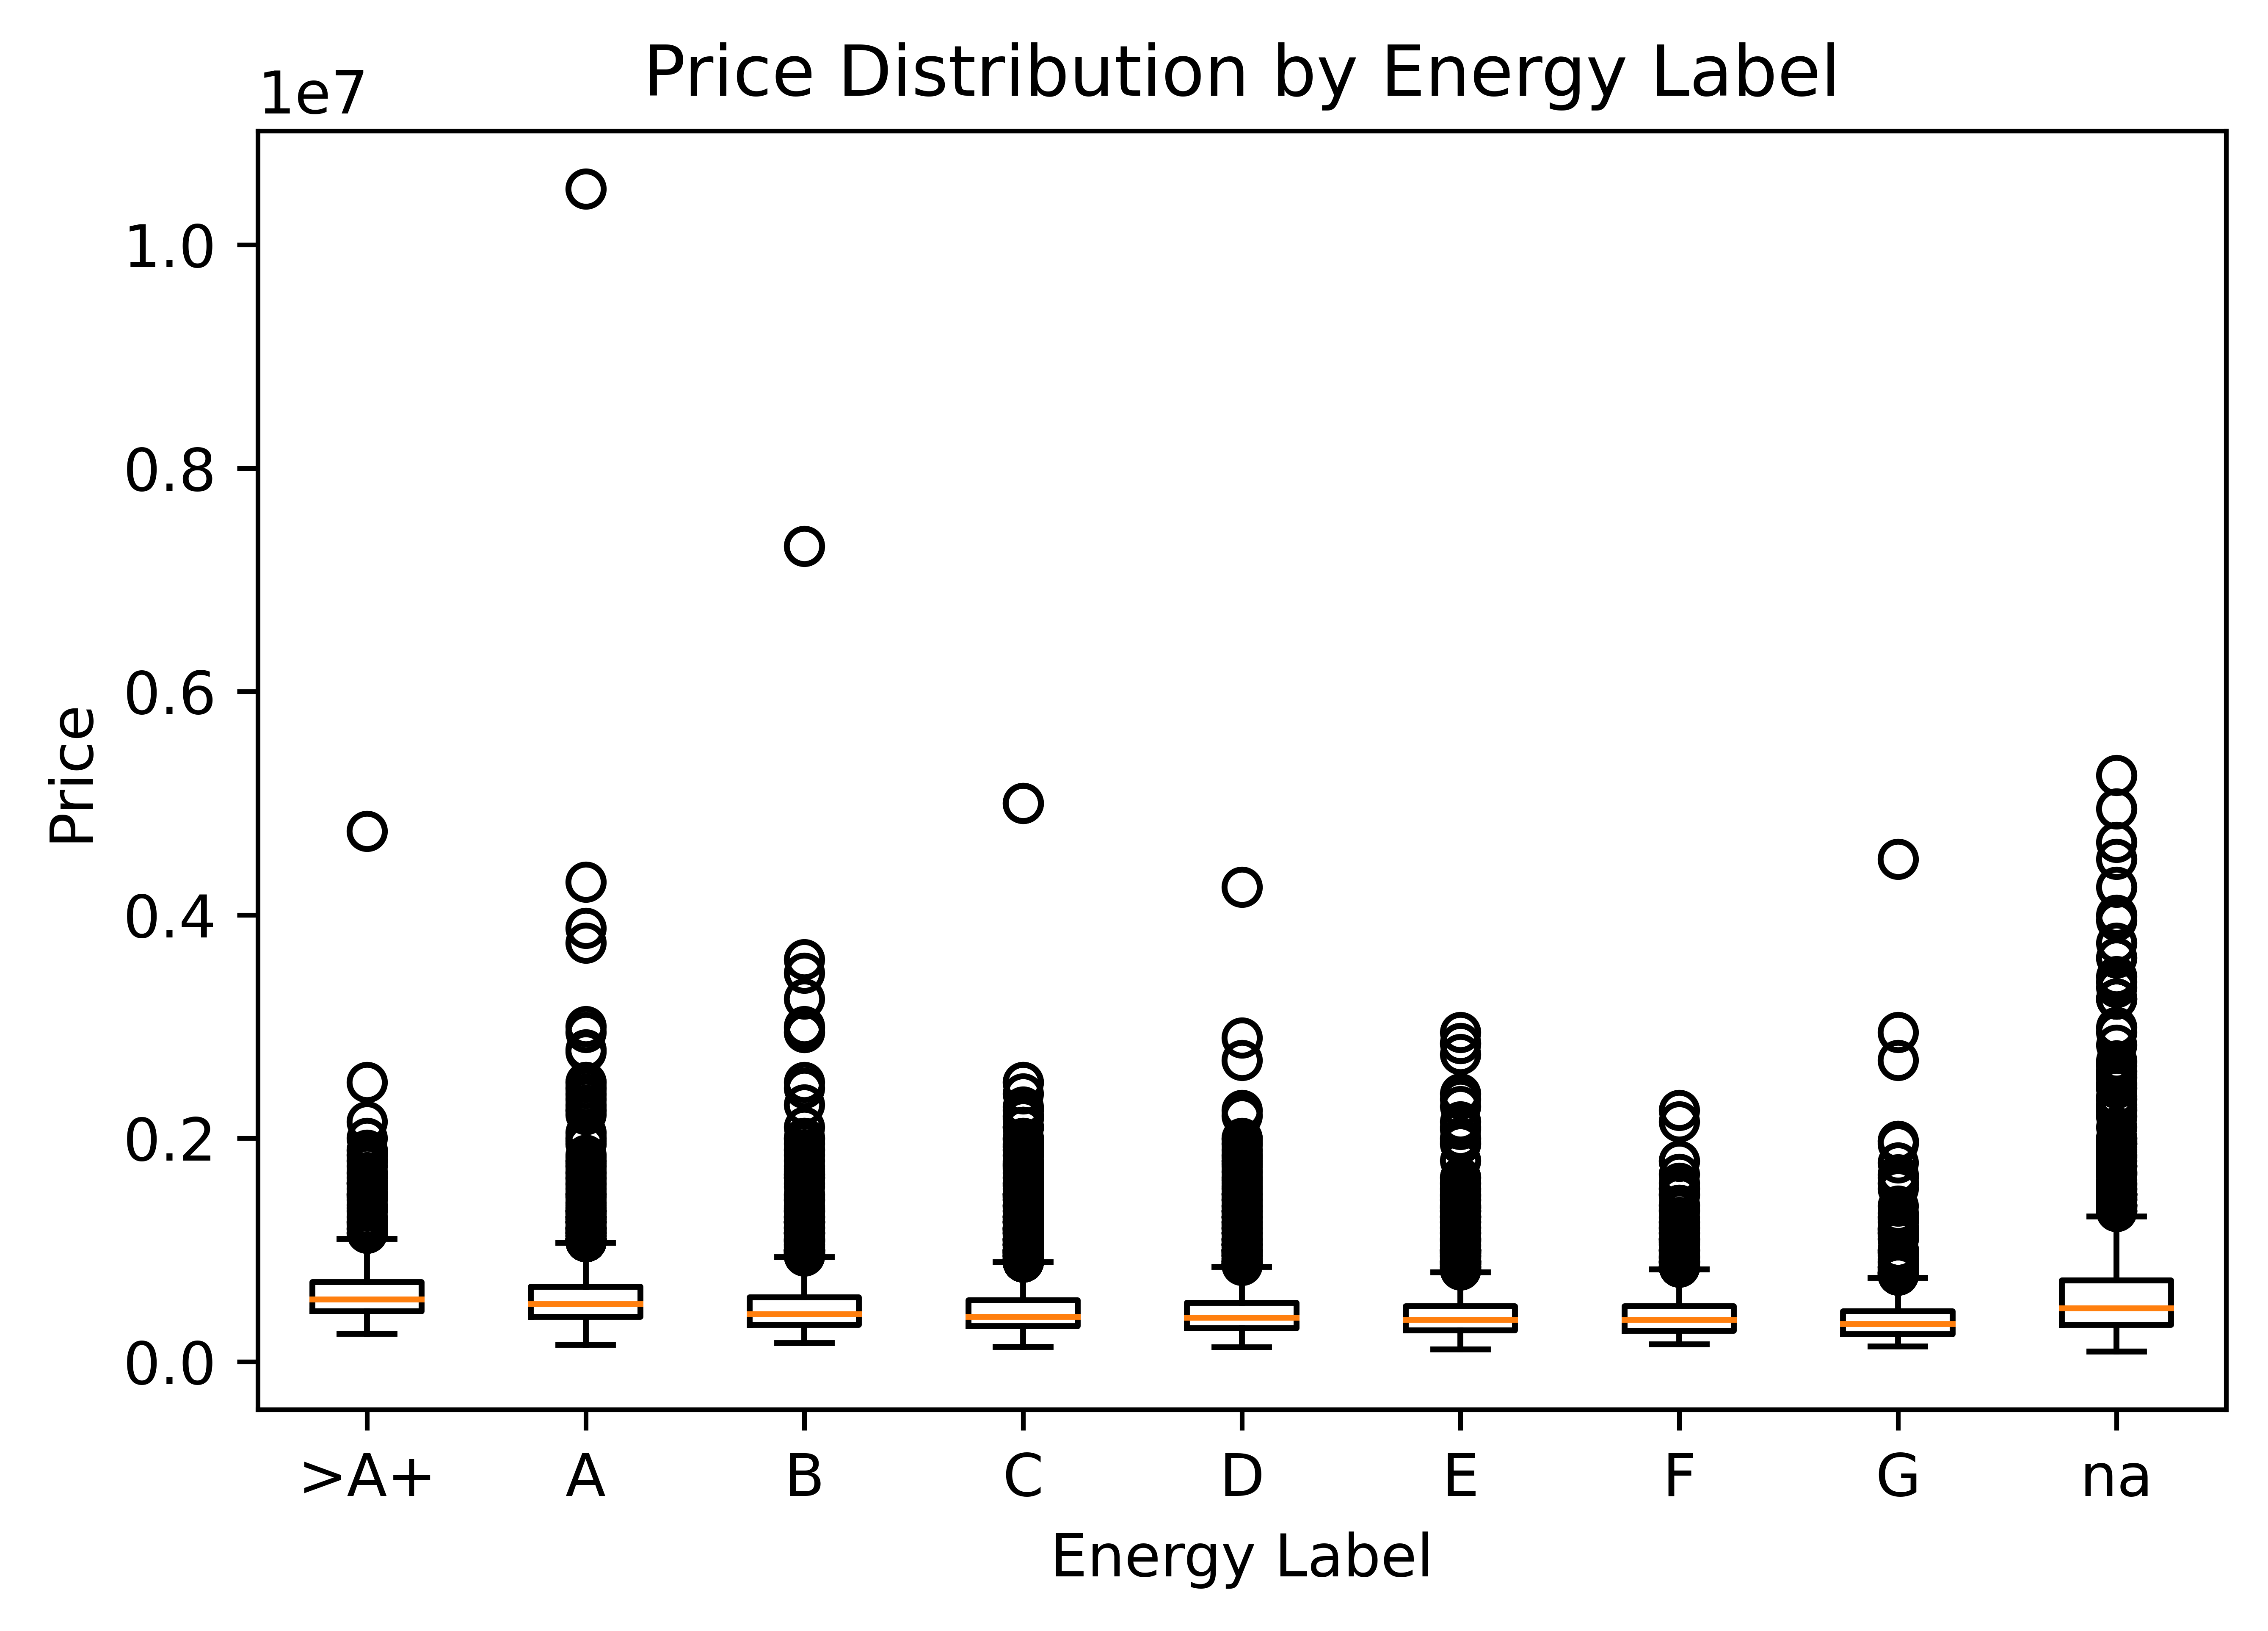

In [5]:
#ploting the realtionship between the energy labels and properties prices 

# Creating a dictionary to group prices by energy label
d = {}
for price, label in zip(funda['price'] , funda["energy_label"]):
    if label not in d:
        d[label] = []
    d[label].append(price)

# Creating a list of prices for each energy label
label_prices = [d[label] for label in sorted(d.keys())]

# Plotting the boxplot
plt.figure(dpi=1000)
plt.boxplot(label_prices, labels=sorted(d.keys()))
plt.xlabel('Energy Label')
plt.ylabel('Price')
plt.title('Price Distribution by Energy Label')
plt.show()
#plt.savefig('Price Distribution by Energy Label', dpi=300)

Visually, this boxplot doesn't add much value since the amount of data is big and each label has a lot of outliers



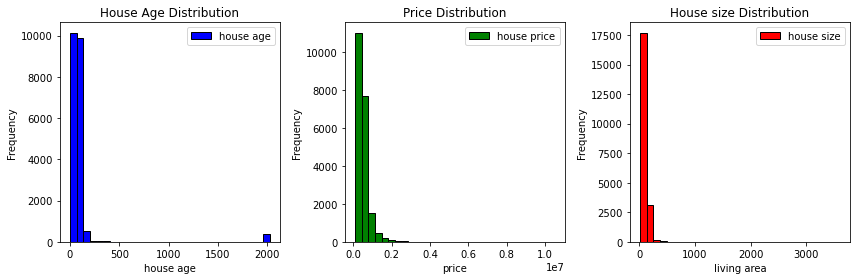

In [6]:
#plot the histogram of the Price, Living area, and house age variables

# Create a figure with three subplots in one row
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plot the histograms in separate subplots

axes[0].hist(funda["house_age"], bins=30, edgecolor='black', label='house age', color='blue')
axes[1].hist(funda["price"], bins=30, edgecolor='black', label='house price', color='green')
axes[2].hist(funda["living_area"], bins=30, edgecolor='black', label='house size', color='red')

# Add labels and legends to each subplot
axes[0].set_xlabel('house age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('House Age Distribution')
axes[0].legend()

axes[1].set_xlabel('price')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution')
axes[1].legend()

axes[2].set_xlabel('living area')
axes[2].set_ylabel('Frequency')
axes[2].set_title('House size Distribution')
axes[2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
#plt.show()
plt.savefig(' Distribution1.png',dpi=1000)


it was also noticed that the price per m2 can be calculated by dividing the house price by the house size, which means that it is essentially redundant information. So it doesn’t add extra information to the data set. For that reason we won’t include it in our outlier analysis 

In [10]:
variables=['price','living_area','house_age']

# Calculate the correlation matrix
correlation_matrix = funda[variables].corr()

# Print the correlation matrix
corr_mat = tabulate(correlation_matrix,  headers=variables,  tablefmt='grid')
print(corr_mat)

+-------------+----------+---------------+-------------+
|             |    price |   living_area |   house_age |
+=============+==========+===============+=============+
| price       | 1        |      0.639833 |    0.097294 |
+-------------+----------+---------------+-------------+
| living_area | 0.639833 |      1        |   -0.01271  |
+-------------+----------+---------------+-------------+
| house_age   | 0.097294 |     -0.01271  |    1        |
+-------------+----------+---------------+-------------+


## Cleaning 

In [11]:
#determine the How many duplicated values we have in the data set 
len(funda[funda.duplicated(subset=['city','zip','street','number','suffix','date_sold'])])

33

In [12]:
#delete the duplicated houses from the data frame
funda= funda.drop_duplicates(subset=['city','zip','street','number','suffix','date_sold'], keep='first')

In [15]:
len(funda[funda['energy_label']=='A'])

4287

In [14]:
len(funda[funda['energy_label']=='>A+'])

688

In [16]:
#replace >A+ with A
funda['energy_label']=funda.energy_label.replace('>A+','A+')
funda["energy_label"]=funda["energy_label"].replace('A+','A')

In [18]:
#the amount of na values in energy label variables, these values can't be imputated
#and we can't get information out of it about the relationship between the energy labels and house prices 
len(funda[(funda['energy_label']=='na')])

1816

In [19]:
#Deleting the na values
funda=funda[~(funda['energy_label']=='na')]

In [20]:
#how many values have 2023 as its age
len(funda[(funda['house_age']==2023)])

271

In [21]:
# we don't know is it the built year or not, it was better to delete them, in order not to have a wrong values in the data 
funda=funda[~(funda['house_age']==2023)]

# Recheck the outliers after cleaning then delete the outliers

### finiding the outlier based on observations and IQR


Finding outliers using statistical methods
Since the data doesn’t follow a normal distribution, we will calculate the outlier data points using the statistical method called interquartile range (IQR) instead of using Z-score. Using the IQR, the outlier data points are the ones falling below Q1–1.5 IQR or above Q3 + 1.5 IQR. The Q1 is the 25th percentile and Q3 is the 75th percentile of the dataset, and IQR represents the interquartile range calculated by Q3 minus Q1 (Q3–Q1).

In [6]:
#create function to detect the outliers 
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    
    return outliers

In [23]:
#price outliers
outliers = find_outliers_IQR(funda["price"])

print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))

outliers


number of outliers: 986
max outlier value: 10500000
min outlier value: 955000


2       3250000
10      1300000
36      1420000
61       985000
63       985000
         ...   
4680     995000
4704    1225000
4765    1085000
4766    1150000
4818    1275000
Name: price, Length: 986, dtype: int64

In [24]:
#determine the outliers in the data set. in case we use personal judgment (the values with price above 2000,000 are outliers)
len(funda[funda["price"]>=2000000])

76

In [26]:
#house age outliers
outliers = find_outliers_IQR(funda["house_age"])

print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))

outliers

number of outliers: 44
max outlier value: 573
min outlier value: 198


39      261
69      199
438     366
533     198
620     207
1337    383
1677    273
1742    264
2545    373
2612    357
2953    273
3708    400
3974    203
4058    207
4123    283
4238    293
4289    268
4413    207
5453    300
5721    373
6259    271
6311    387
6761    285
6780    250
6848    233
6992    200
7467    207
7542    321
7812    403
8045    373
8166    250
8184    267
8295    216
1530    398
1738    573
1918    360
1989    199
2068    398
2448    573
3011    573
1384    224
2149    273
2947    273
4108    203
Name: house_age, dtype: int64

In [27]:
#determine the outliers in the data set.
len(funda[funda["house_age"]>=198])

44

In [28]:
#house size outliers
outliers = find_outliers_IQR(funda["living_area"])

print('number of outliers: '+ str(len(outliers)))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))

outliers

number of outliers: 654
max outlier value: 666
min outlier value: 185


2       229
36      238
86      258
123     186
148     190
       ... 
4722    210
4758    191
4765    188
4766    234
4818    260
Name: living_area, Length: 654, dtype: int64

In [29]:
#determine the outliers in the data set. in case we followed our personal judgment 
len(funda[funda["living_area"]>=300])

53

In [30]:
#delete the outliers
funda=funda[~(funda["price"]>=2000000)]

#delete the outliers
funda=funda[~(funda["house_age"]>=198)]

#delete the outliers
funda=funda[~(funda["living_area"]>=300)]

len(funda)

18794

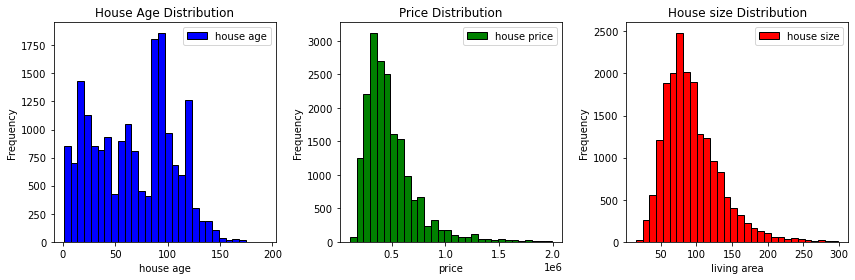

In [31]:
#plot the histogram of the Price, Living area, and house age variables after cleaning

# Create a figure with three subplots in one row
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))


# Plot the histograms in separate subplots
axes[0].hist(funda["house_age"], bins=30, edgecolor='black', label='house age', color='blue')
axes[1].hist(funda["price"], bins=30, edgecolor='black', label='house price', color='green')
axes[2].hist(funda["living_area"], bins=30, edgecolor='black', label='house size', color='red')

# Add labels and legends to each subplot
axes[0].set_xlabel('house age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('House Age Distribution')
axes[0].legend()

axes[1].set_xlabel('price')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution')
axes[1].legend()

axes[2].set_xlabel('living area')
axes[2].set_ylabel('Frequency')
axes[2].set_title('House size Distribution')
axes[2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

plt.savefig(' Distribution2.png',dpi=1000)
# Display the plot
#plt.show()

## preprocessing for later merging 

In [32]:
# creating new columns for month and year of sold

funda['date_sold'] = pd.to_datetime(funda['date_sold'])

# Extract the month from the 'date_sold' column
# Extract the month and year from the 'date_sold' column
funda['month_sold'] = funda['date_sold'].dt.month
funda['year_sold'] = funda['date_sold'].dt.year


In [33]:
# creating a column the contain the quarter and the year of sold

def month_to_quarter (month):
    if month in [1,2,3]:
        return '1st quarter'
    elif month in [4,5,6]:
        return '2nd quarter'
    elif month in [7,8,9]:
        return '3rd quarter'
    else: return '4th quarter'
    
    
#create the quarter column
funda['quarter_sold'] = funda['month_sold'].apply(month_to_quarter)
#combine the quarter and year sold
funda['period'] = funda['year_sold'].astype(str) + ' ' + funda['quarter_sold']

### House Price Index data 

In [34]:
#reading the second dataset
HPI=pd.read_csv(r'C:\Users\dodih\Documents\Python Scripts\Thesis data\Data\HPI randstad.csv', sep=';')

In [35]:
HPI

,Periods,Regions,Price index of existing own homes/Price index purchase prices (2015=100)
0,2021 1st quarter,Amsterdam,168.1
1,2021 2nd quarter,Amsterdam,174.5
2,2021 3rd quarter,Amsterdam,188.1
3,2021 4th quarter,Amsterdam,190.2
4,2022 1st quarter,Amsterdam,199.5
5,2022 2nd quarter,Amsterdam,204.4
6,2022 3rd quarter,Amsterdam,204.1
7,2022 4th quarter,Amsterdam,192.4
8,2023 1st quarter,Amsterdam,188.2
9,2021 1st quarter,'s-Gravenhage (The Hague) (municipality),166.6


## cleaning

In [37]:
#change the names of the cities
HPI.loc[HPI.Regions.str.contains('(The Hague)'),'Regions']='den-haag'

HPI.loc[HPI.Regions.str.contains('Utrecht'),'Regions']='utrecht'

HPI.loc[HPI.Regions.str.contains('Amsterdam'),'Regions']='amsterdam'

HPI.loc[HPI.Regions.str.contains('Rotterdam'),'Regions']='rotterdam'

C:\Users\dodih\AppData\Local\Temp\ipykernel_22348\2124855014.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  HPI.loc[HPI.Regions.str.contains('(The Hague)'),'Regions']='den-haag'


In [38]:
#change the names of the column
HPI.rename(columns={'Price index of existing own homes/Price index purchase prices (2015=100)': 'price_index'}, inplace=True)

## preprocessing

In [39]:
#change the index column value to percentage for easier interpretation

for i in range(len(HPI)):
    index=HPI['price_index'][i]- 100
    HPI['price_index'][i]=index/100

C:\Users\dodih\AppData\Local\Temp\ipykernel_22348\1460873369.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HPI['price_index'][i]=index/100


## merging both data sets

In [40]:
funda_HPI=funda.merge(HPI, left_on=['city','period'], right_on=['Regions','Periods'], how='inner')

In [42]:
#the values that were deleted in the merge since we don't have this value in the HPI
#(The HPI data were downloaded in the 2nd quarter of 2023 that's why the HPI for this quartervwas not calculated yet )

len(funda[funda['period']=='2023 2nd quarter'])

962

In [43]:
#the length of the merged data set that was used for this study
len(funda_HPI)

17832

In [44]:
funda_HPI.columns

Index(['city', 'house_type', 'price', 'price_m2', 'living_area',
       'energy_label', 'zip', 'address', 'year_built', 'house_age',
       'date_list', 'term_days', 'date_sold', 'street', 'number', 'suffix',
       'extra', 'month_sold', 'year_sold', 'quarter_sold', 'period', 'Periods',
       'Regions', 'price_index'],
      dtype='object')

##  transformation


In [45]:
# Applying log transformation
log_house_age = np.log(funda_HPI["house_age"])
log_living_area = np.log(funda_HPI["living_area"])
log_house_price = np.log(funda_HPI["price"])

In [46]:
funda_HPI['log_house_area']=log_living_area 
funda_HPI['log_house_age']=log_house_age
funda_HPI['log_house_price']=log_house_price

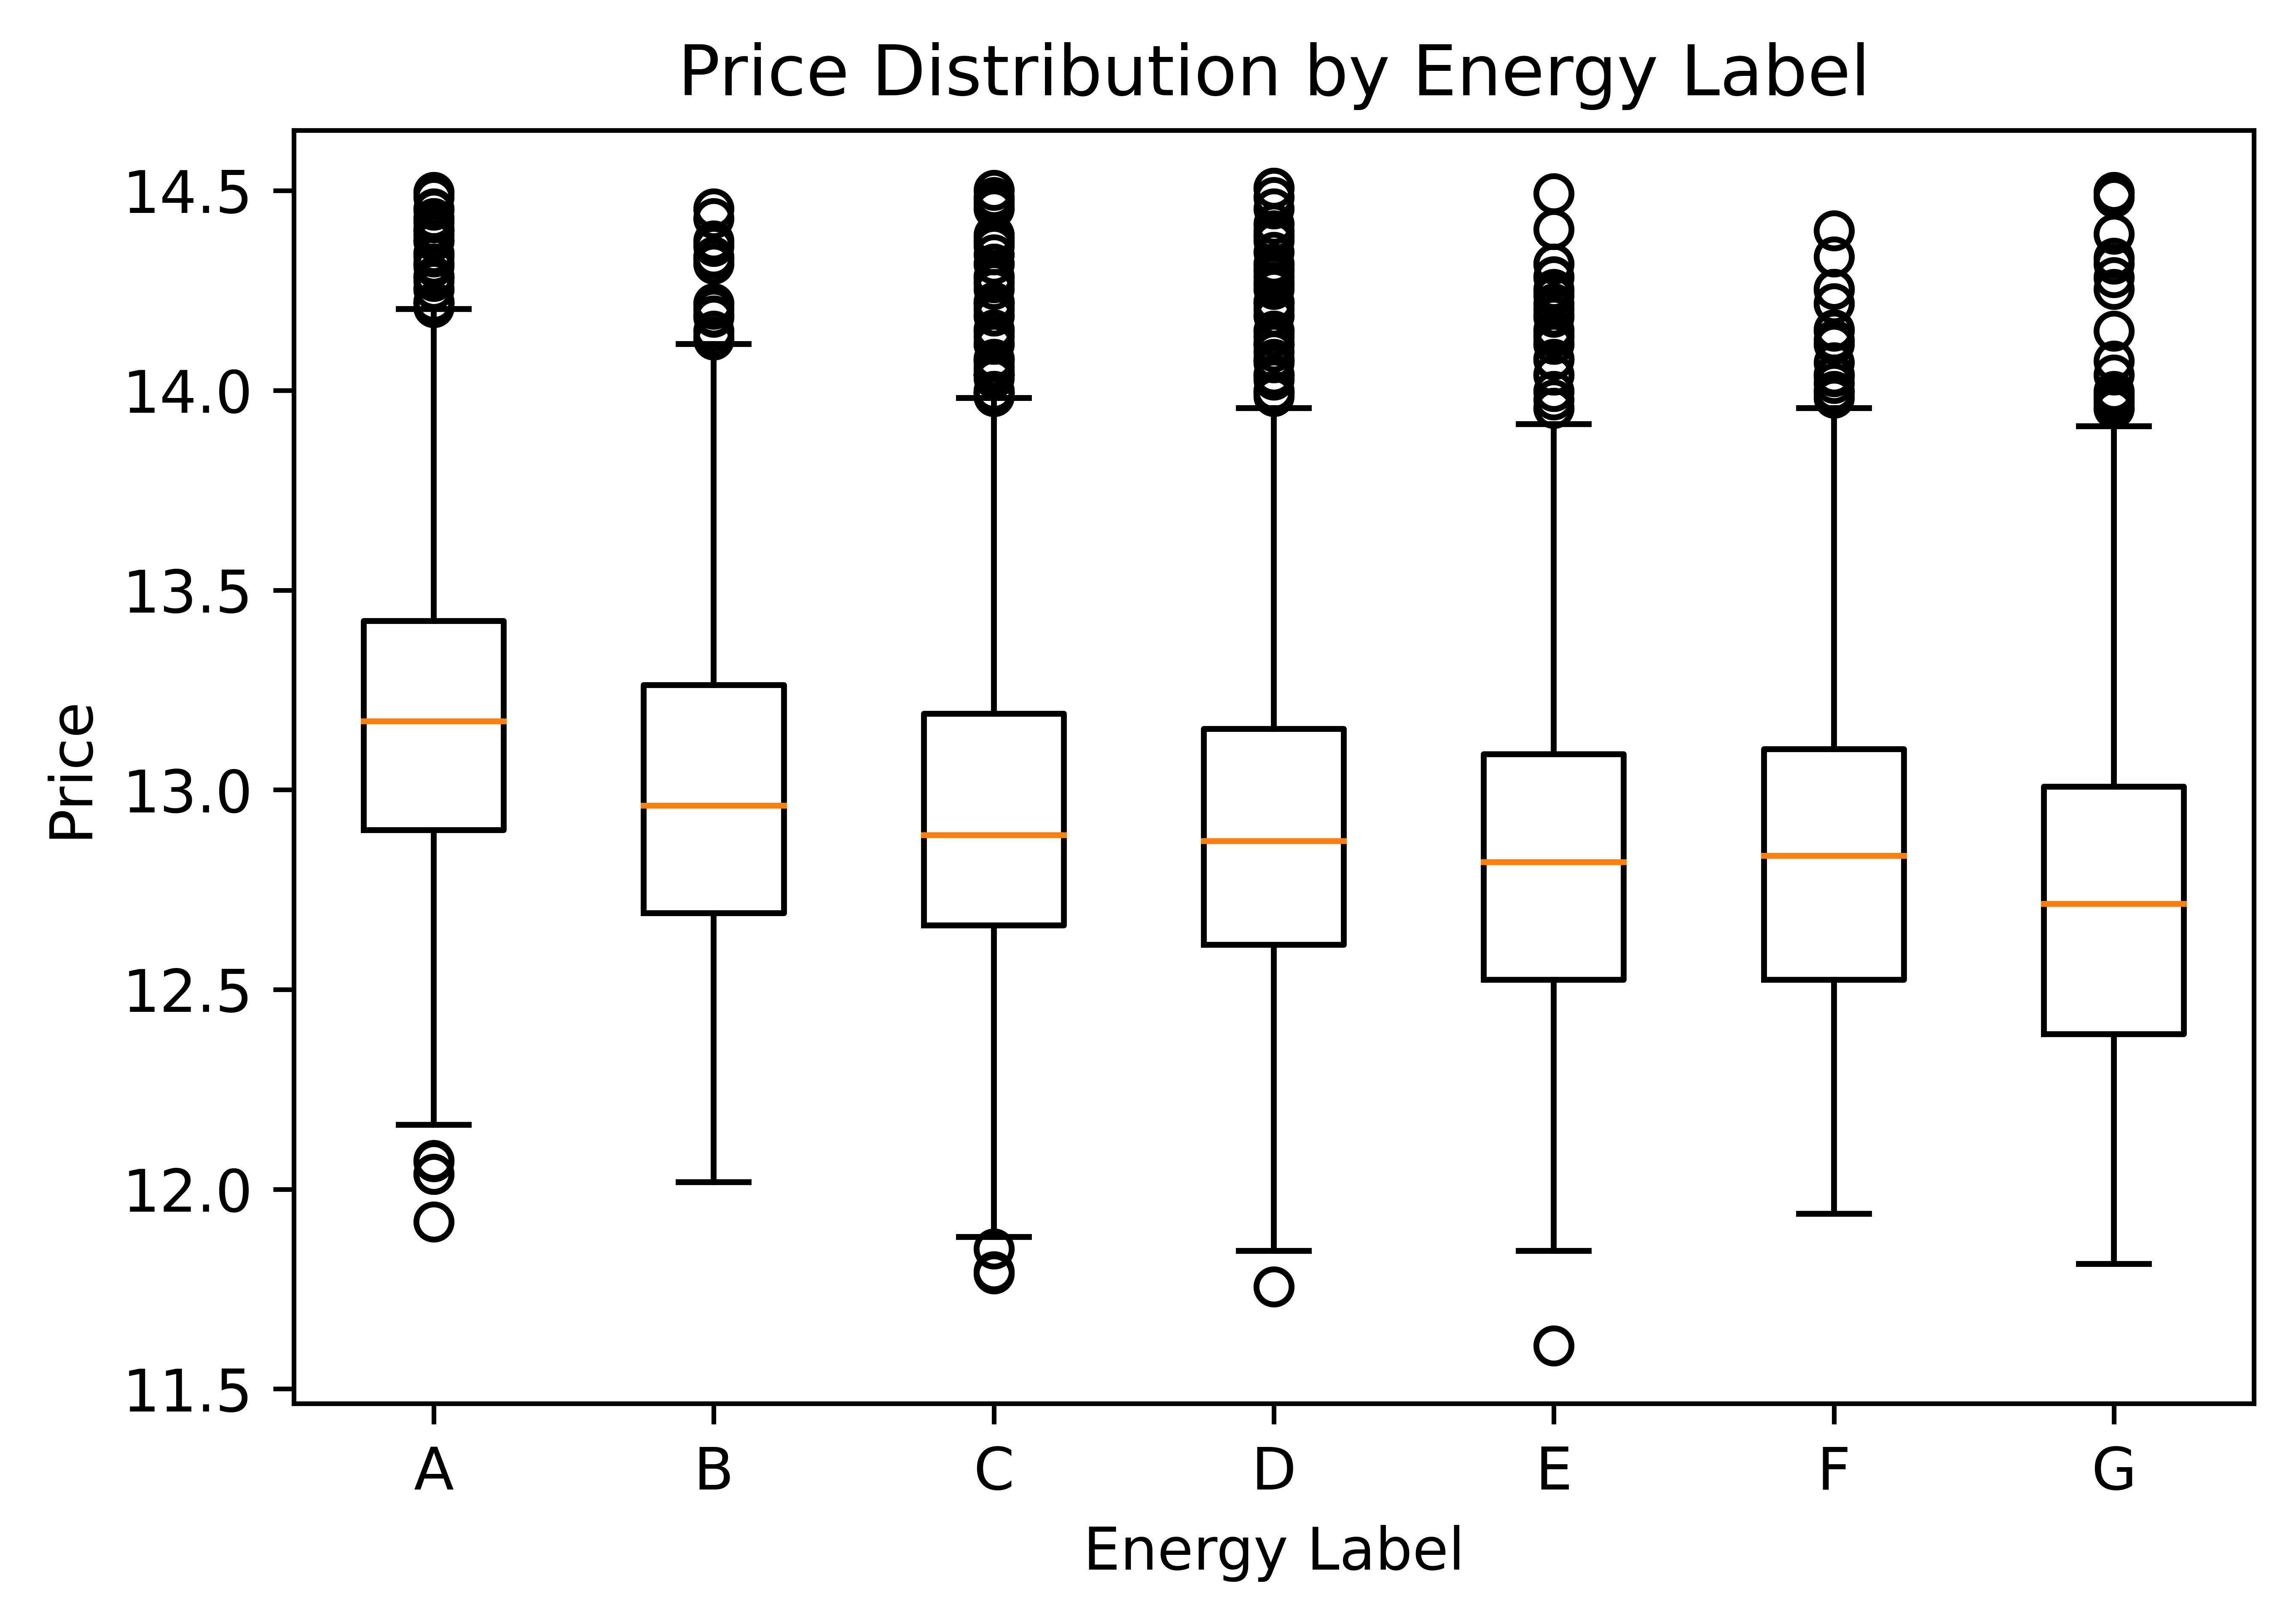

In [47]:
# Creating a dictionary to group prices by energy label
d = {}
for price, label in zip(log_house_price , funda_HPI["energy_label"]):
    if label not in d:
        d[label] = []
    d[label].append(price)

# Creating a list of prices for each energy label
label_prices = [d[label] for label in sorted(d.keys())]

plt.figure(dpi=1000)
# Plotting the boxplot
plt.boxplot(label_prices, labels=sorted(d.keys()))
plt.xlabel('Energy Label')
plt.ylabel('Price')
plt.title('Price Distribution by Energy Label')
plt.show()



Visually, it appears that the mean prices of houses with an energy label A are generally higher compared to houses with other labels.

In [48]:
#the number of data points per energy label, which introduce bias in the modeling results per energy label, 
#therfore our modeling results for energy labels will interpreted as a whole block not per energy label
funda_HPI['energy_label'].value_counts()

A    4642
C    4185
D    3205
B    2179
E    1890
F     991
G     740
Name: energy_label, dtype: int64

In [49]:
#saving the final data set 
funda_HPI.to_csv('C:/Users/dodih/Documents/Python Scripts/Thesis data/Data/funda_HPI.csv',  index=False)